In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train = np.loadtxt('../../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

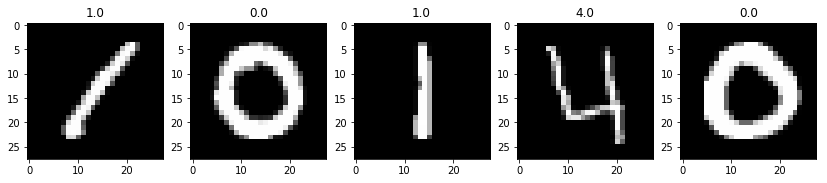

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [5]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [6]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

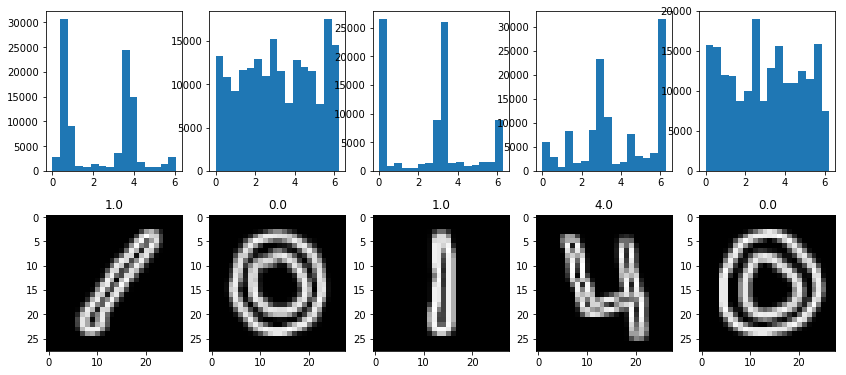

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [8]:
#функция для разделения исходного изображения на 4 части
def split_to_4(ary):
    ny, nx = ary.shape
    sub1 = ary[0:(ny//2), 0:(nx//2)]
    sub2 = ary[0:(ny//2), (nx//2):nx]
    sub3 = ary[(ny//2):ny, 0:(nx//2)]
    sub4 = ary[(ny//2):ny, (nx//2):nx]
    return [sub1, sub2, sub3, sub4]

In [9]:
train_g_split = np.array([split_to_4(ary) for ary in train_g])

In [10]:
train_theta_split = np.array([split_to_4(ary) for ary in train_theta])

In [11]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [12]:
test_g_split = np.array([split_to_4(ary) for ary in test_g])
test_theta_split = np.array([split_to_4(ary) for ary in test_theta])

## Вычисляем гистограммы градиентов

In [13]:
n_bins=16 #количество бинов гистограмм для "четвертинок" изображений

In [14]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 4*n_bins))
for i in range(len(train_img)):
    hist = np.ndarray(0)
    for j in range(4):
        dum_hist, borders = np.histogram(train_theta_split[i,j],
                                 bins=n_bins,
                                 range=(0., 2. * np.pi),
                                 weights=train_g_split[i,j])
        hist = np.append(hist, dum_hist)
    train_hist[i] = hist

In [15]:
test_hist = np.zeros((len(test_img), 4*n_bins))
for i in range(len(test_img)):
    hist = np.ndarray(0)
    for j in range(4):
        dum_hist, borders = np.histogram(test_theta_split[i,j],
                                 bins=n_bins,
                                 range=(0., 2. * np.pi),
                                 weights=test_g_split[i,j])
        hist = np.append(hist, dum_hist)
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [16]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [17]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [18]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

In [19]:
def make_model(x_train, n_layers, n_neurons, act_function):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_neurons, input_dim=x_train.shape[1], activation=act_function))
    for i in range(1, n_layers):
        model.add(keras.layers.Dense(n_neurons, activation=act_function))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [21]:
kfold = KFold(4, shuffle=True)
params = {'x_train': [x_train], 'n_layers': [2,3,4], 'n_neurons': [32,64,128,256], 'act_function': ['relu','tanh']}

In [22]:
from keras.wrappers.scikit_learn import KerasClassifier
k_model = KerasClassifier(build_fn=make_model)

In [23]:
def my_accuracy_score(y_true_mult_array, y_pred_single_array):
    mask = np.linspace(0, 9, 10)
    y_true_single_array = np.zeros((y_true_mult_array.shape[0]))
    for i in range(y_true_mult_array.shape[0]):
        val = y_true_mult_array[i]
        dig = np.dot(val,mask)
        y_true_single_array[i] = dig
    return accuracy_score(y_true_single_array, y_pred_single_array)

In [24]:
f_params = {'verbose': False, 'epochs': 15}

In [25]:
gs = GridSearchCV(estimator=k_model, param_grid=params, fit_params = f_params, \
                  cv=kfold, scoring=make_scorer(my_accuracy_score), n_jobs=1, verbose=False)

In [26]:
gs.fit(x_train, y_train_labels)

24512/25200 [============================>.] - ETA: 0s

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000029990863EB8>,
       fit_params={'verbose': False, 'epochs': 15}, iid=True, n_jobs=1,
       param_grid={'x_train': [array([[ 0.47379,  0.21876, ...,  0.     ,  0.02654],
       [ 0.09353,  0.05729, ...,  0.     ,  0.01284],
       ...,
       [ 0.22104,  0.44306, ...,  0.01949,  0.06945],
       [ 0.19269,  0.09236, ...,  0.     ,  0.     ]])], 'n_layers': [2, 3, 4], 'n_neurons': [32, 64, 128, 256], 'act_function': ['relu', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(my_accuracy_score), verbose=False)

In [27]:
gs.best_params_

{'act_function': 'relu',
 'n_layers': 2,
 'n_neurons': 256,
 'x_train': array([[ 0.4737933 ,  0.21876205,  0.02319344, ...,  0.02511571,
          0.        ,  0.02654478],
        [ 0.09353285,  0.05728732,  0.15945066, ...,  0.02385887,
          0.        ,  0.01284459],
        [ 0.07612001,  0.11579417,  0.13698659, ...,  0.04494156,
          0.12107714,  0.13547792],
        ..., 
        [ 0.06738247,  0.0552646 ,  0.21805288, ...,  0.01079181,
          0.00218099,  0.        ],
        [ 0.22104381,  0.44306123,  0.09857426, ...,  0.04041774,
          0.01949441,  0.0694476 ],
        [ 0.19268832,  0.0923633 ,  0.14630039, ...,  0.        ,
          0.        ,  0.        ]])}

In [29]:
gs.best_score_

0.9693154761904762

In [31]:
b_estimator = gs.best_estimator_

In [32]:
b_estimator.fit(x_train, y_train_labels)

Epoch 1/10
33600/33600 [==============================] - 5s - loss: 0.3488 - acc: 0.9016     
Epoch 2/10
33600/33600 [==============================] - 4s - loss: 0.1668 - acc: 0.9473     
Epoch 3/10
33600/33600 [==============================] - 5s - loss: 0.1332 - acc: 0.9576     
Epoch 4/10
33600/33600 [==============================] - 4s - loss: 0.1098 - acc: 0.9641     
Epoch 5/10
33600/33600 [==============================] - 4s - loss: 0.0955 - acc: 0.9696     
Epoch 6/10
33600/33600 [==============================] - 4s - loss: 0.0849 - acc: 0.9730     
Epoch 7/10
33600/33600 [==============================] - 4s - loss: 0.0736 - acc: 0.9758     
Epoch 8/10
33600/33600 [==============================] - 4s - loss: 0.0671 - acc: 0.9772     
Epoch 9/10
33600/33600 [==============================] - 4s - loss: 0.0587 - acc: 0.9799     
Epoch 10/10
33600/33600 [==============================] - 5s - loss: 0.0525 - acc: 0.9826     


## Предсказываем класс объекта

In [34]:
pred_val = b_estimator.predict(x_val)

7648/8400 [==========================>...] - ETA: 0s

## Оцениваем качество решение на валидационной выборке

In [35]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.968214285714


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       816
        1.0       0.99      0.99      0.99       909
        2.0       0.99      0.96      0.97       846
        3.0       0.95      0.97      0.96       937
        4.0       0.97      0.96      0.96       839
        5.0       0.98      0.94      0.96       702
        6.0       0.95      0.97      0.96       785
        7.0       0.99      0.95      0.97       893
        8.0       0.95      0.96      0.95       835
        9.0       0.94      0.98      0.96       838

avg / total       0.97      0.97      0.97      8400



In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[807   0   0   1   3   0   2   0   2   1]
 [  0 900   0   2   2   0   4   0   0   1]
 [  0   0 815  17   1   1   4   2   6   0]
 [  1   1   2 911   0   8   1   2  10   1]
 [  0   2   1   0 807   0  12   2   1  14]
 [  1   0   0  14   2 662   8   0  12   3]
 [  4   2   1   0  10   1 763   1   3   0]
 [  0   2   6  11   2   2   0 849   2  19]
 [  4   1   1   1   4   2  10   2 801   9]
 [  0   1   1   1   4   1   0   3   9 818]]


## Предсказания на тестовыйх данных

In [39]:
pred_test = b_estimator.predict(test_hist)

27968/28000 [============================>.] - ETA: 0s

## Визуализируем предсказания

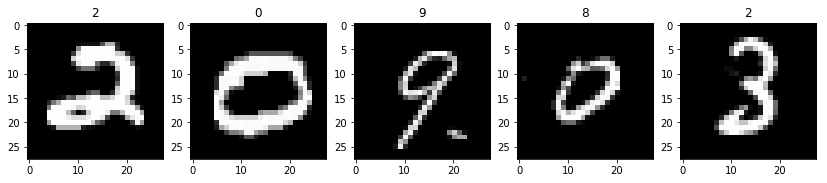

In [40]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [42]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.59843